# Descripción del proyecto.
---
Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Nuestro objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizaremos un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización.

In [69]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import spacy
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

pd.__version__

'2.2.2'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.style.use('seaborn-v0_8')

In [3]:
tqdm.pandas()

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Cargar datos.
---
Para entrenar un modelo que pueda procesar el lenguaje natural se necesita bastante el uso de memoria, por lo tanto vamos a tratar de disminuir un poco el consumo. 

In [4]:
df = pd.read_csv(r"C:\Users\\Downloads\imdb_reviews.tsv", sep='\t')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [6]:
print(df
 .memory_usage(deep=True)
 .sum()
)

90576294


In [7]:
df = pd.read_csv(r"C:\Users\\Downloads\imdb_reviews.tsv", sep='\t', engine='pyarrow', dtype_backend='pyarrow')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   tconst           47331 non-null  string[pyarrow]
 1   title_type       47331 non-null  string[pyarrow]
 2   primary_title    47331 non-null  string[pyarrow]
 3   original_title   47331 non-null  string[pyarrow]
 4   start_year       47331 non-null  int64[pyarrow] 
 5   end_year         47331 non-null  string[pyarrow]
 6   runtime_minutes  47331 non-null  string[pyarrow]
 7   is_adult         47331 non-null  int64[pyarrow] 
 8   genres           47331 non-null  string[pyarrow]
 9   average_rating   47329 non-null  double[pyarrow]
 10  votes            47329 non-null  int64[pyarrow] 
 11  review           47331 non-null  string[pyarrow]
 12  rating           47331 non-null  int64[pyarrow] 
 13  sp               47331 non-null  string[pyarrow]
 14  pos              47331

In [9]:
print(df
 .memory_usage(deep=True)
 .sum()
)

69099637


In [10]:
def shrink_ints(df):
    mapping = {}
    for col in df.dtypes[df.dtypes=='int64[pyarrow]'].index:
        max_ = df[col].max()
        min_ = df[col].min()
        if min_ < 0:
            continue
        if max_ < 255:
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:
            mapping[col] = 'uint16[pyarrow]'
        elif max_ <  4294967295:
            mapping[col] = 'uint32[pyarrow]'
    return df.astype(mapping)


def clean_housing(df):
    return (df
     .assign(**df.select_dtypes('string').replace('', 'Missing').astype('category'))
     .pipe(shrink_ints)
    ) 

In [11]:
df = clean_housing(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   tconst           47331 non-null  category       
 1   title_type       47331 non-null  category       
 2   primary_title    47331 non-null  category       
 3   original_title   47331 non-null  category       
 4   start_year       47331 non-null  uint16[pyarrow]
 5   end_year         47331 non-null  category       
 6   runtime_minutes  47331 non-null  category       
 7   is_adult         47331 non-null  uint8[pyarrow] 
 8   genres           47331 non-null  category       
 9   average_rating   47329 non-null  double[pyarrow]
 10  votes            47329 non-null  uint32[pyarrow]
 11  review           47331 non-null  category       
 12  rating           47331 non-null  uint8[pyarrow] 
 13  sp               47331 non-null  category       
 14  pos              47331

In [13]:
print(df
 .memory_usage(deep=True)
 .sum()
)

65213832


In [14]:
print(90_576_294/65_213_832)

1.3889123092781912


Pudimos disminuir el uso de memoria casi 1.39 veces, esto nos ayudara a hacer el proceso mas eficiente.

## Análisis inicial.
---
Vamos a conocer un poco más nuestro dataset, tendencias, frecuencias, si existe un desbalance en las clases, y demás. 

In [15]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [16]:
df.query('`votes`.isna()')

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,<NA>,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,<NA>,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [17]:
df.select_dtypes('category').describe().T

,count,unique,top,freq
tconst,47331,6648,tt0171580,30
title_type,47331,10,movie,36861
primary_title,47331,6555,The Sentinel,60
original_title,47331,6562,The Sentinel,60
end_year,47331,60,\N,45052
runtime_minutes,47331,249,90,2442
genres,47331,585,Drama,3392
review,47331,47240,Loved today's show!!! It was a variety and not...,5
sp,47331,2,neg,23715
ds_part,47331,2,train,23796


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
start_year,47331.0,1989.631235,19.600364,1894.0,1982.0,1998.0,2004.0,2010.0
is_adult,47331.0,0.001732,0.041587,0.0,0.0,0.0,0.0,1.0
average_rating,47329.0,5.998278,1.494289,1.4,5.1,6.3,7.1,9.7
votes,47329.0,25562.917323,83670.039163,9.0,827.0,3197.0,13974.0,1739448.0
rating,47331.0,5.484608,3.473109,1.0,2.0,4.0,9.0,10.0
pos,47331.0,0.498954,0.500004,0.0,0.0,0.0,1.0,1.0
idx,47331.0,6279.697999,3605.702545,0.0,3162.0,6299.0,9412.0,12499.0


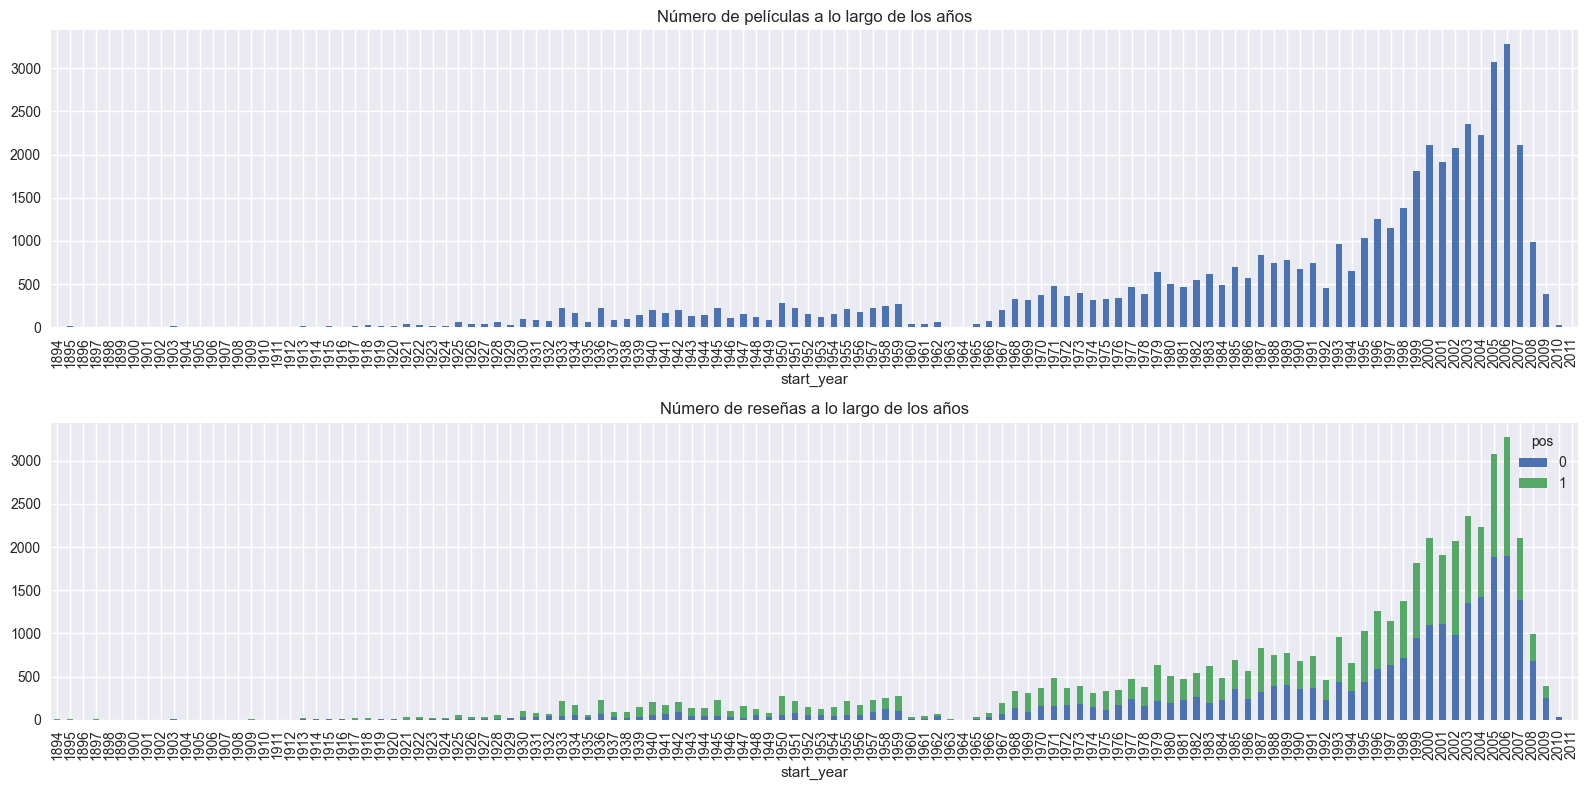

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2012))).fillna(0)

dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2012))).fillna(0)

dft2.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

C:\Users\luisP\AppData\Local\Temp\ipykernel_32276\2199187402.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dft = df.groupby('tconst')['review'].count() \
C:\Users\luisP\AppData\Local\Temp\ipykernel_32276\2199187402.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dft = df.groupby('tconst')['review'].count()


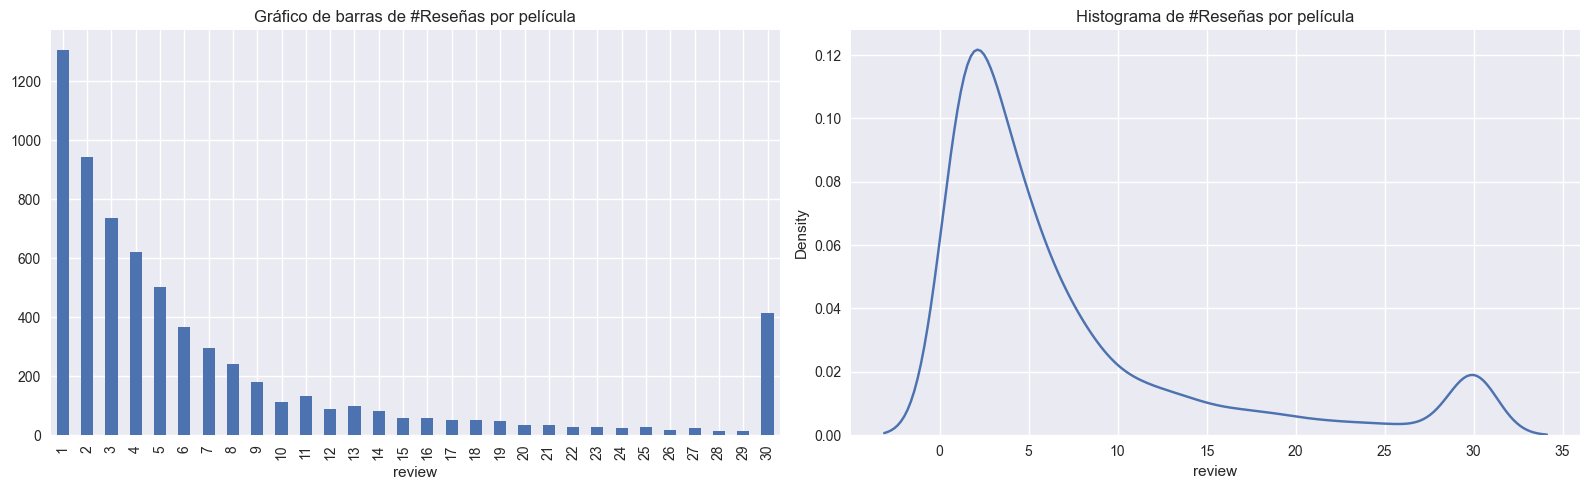

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Histograma de #Reseñas por película')

fig.tight_layout()

In [21]:
print(df['pos'].value_counts())
print(df['pos'].value_counts(normalize=True))

pos
0    23715
1    23616
Name: count, dtype: int64[pyarrow]
pos
0    0.501046
1    0.498954
Name: proportion, dtype: double[pyarrow]


Vemos que no existe un desbalance en las clases.

## Preprocesamiento de datos para el modelado.
---
En este paso vamos a limpiar nuestro dataset y dejarlo listo para el desarrollo de los modelos.

In [22]:
df = df[['review', 'pos']]

corpus = df['review']

In [23]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp

In [24]:
def clear_text(text):
    
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)

    return text

def lemmatize(text):

    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)



In [26]:
reviews = []
for i in range(len(df)):
    review = lemmatize(clear_text(corpus[i]))
    reviews.append(review)

reviews

['the pakage imply that warren beatty and goldie hawn be pull off a huge bank robbery but that be not what I get out of it I do not get anything in the first half there be a new character without introduction in every other scene the first half hour be completely incomprehensible the rest be just one long annoying underlit chase scene there be always an irritating sound in the background whether it be a loud watch tick a blaring siren a train whistle or even the horrible score by quincy jones there be a lot of part that be laughably bad too like the bad guy chase beatty on thin ice with a car or the police arrive at the scene roughly fifteen time I really hate this movie',
 'how the hell do they get this make present itself as a caper comedy the misbegotten be essentially two hour of people mumbling sentence fragment the usually dependable warren beatty look drunk and the usually hilarious goldie hawn act like she be on depressant as for gert frobe his most famous role goldfinger be in

In [27]:
df['review_lemm'] = reviews

df.head()

,review,pos,review_lemm
0,The pakage implies that Warren Beatty and Gold...,0,the pakage imply that warren beatty and goldie...
1,How the hell did they get this made?! Presenti...,0,how the hell do they get this make present its...
2,There is no real story the film seems more lik...,0,there be no real story the film seem more like...
3,Um .... a serious film about troubled teens in...,1,um a serious film about troubled teen in singa...
4,I'm totally agree with GarryJohal from Singapo...,1,I be totally agree with garryjohal from singap...


In [28]:
df.tail()

,review,pos,review_lemm
47326,This is another of my favorite Columbos. It sp...,1,this be another of my favorite columbo it spor...
47327,Talk about being boring! I got this expecting ...,0,talk about be bore I get this expect a fascina...
47328,"I never thought I'd say this about a biopic, b...",1,I never think I would say this about a biopic ...
47329,Spirit and Chaos is an artistic biopic of Miya...,1,spirit and chaos be an artistic biopic of miya...
47330,I'll make this brief. This was a joy to watch....,1,I will make this brief this be a joy to watch ...


In [29]:
df = df.drop('review', axis=1)
train, test = train_test_split(df, test_size=0.5, random_state=12345)

train.shape, test.shape

((23665, 2), (23666, 2))

In [30]:
train_corpus = train['review_lemm']
test_corpus = test['review_lemm']

In [94]:
stop_words = set(nltk_stopwords.words('english'))

vectorizer = TfidfVectorizer(stop_words='english')
tf_idf = vectorizer.fit_transform(train_corpus)

In [32]:
train_features = tf_idf
train_target = train['pos']

test_features = vectorizer.transform(test_corpus)
test_target = test['pos']


train_features.shape, test_features.shape

((23665, 60601), (23666, 60601))

In [33]:
np.savez_compressed('features_2.npz', train_features=train_features, test_features=test_features)

## Entrenamiento de modelos.

In [34]:
def metrics(model, features, target):
    predictions = model.predict(features)

    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]

    auc_roc = roc_auc_score(target, probabilities_one)

    f1 = f1_score(target, predictions)

    final_score = cross_val_score(model, features, target, cv=5).mean()

    confusion_matriz = confusion_matrix(target.tolist(), predictions.tolist())

    return auc_roc, f1, final_score, confusion_matriz

### Modelo 1 - Regresión logística. 

In [38]:
%%time
model_1 = LogisticRegression(random_state=54321, solver='liblinear').fit(train_features, train_target)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_1, features=train_features, target=train_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.9798613539870273
F1 score: 0.9302228178924443
Puntuación media de la evaluación del modelo: 0.8785970843017112
Matriz de confusion:
[[10894   980]
 [  686 11105]]
CPU times: total: 1.33 s
Wall time: 2.41 s


In [37]:
auc_roc, f1, final_score, confusion_matriz = metrics(model=model_1, features=test_features, target=test_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.9521614028584882
F1 score: 0.8844433399602386
Puntuación media de la evaluación del modelo: 0.8804615027156538
Matriz de confusion:
[[10199  1642]
 [ 1148 10677]]


Este modelo me sorprendio bastante, usando diferentes metricas nos muestra un buen rendimiento tanto con el dataset de entrenamiento como con el de prueba. 

### Modelo 2 - CatBoost.

In [60]:
%%time
model_2 = CatBoostClassifier(iterations=10, loss_function='Logloss', random_seed=12345).fit(train_features, train_target, verbose=10)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_2, features=train_features, target=train_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Learning rate set to 0.5
0:	learn: 0.5863382	total: 705ms	remaining: 6.34s
9:	learn: 0.4379443	total: 6.66s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5980471	total: 506ms	remaining: 4.56s
1:	learn: 0.5489688	total: 1.03s	remaining: 4.11s
2:	learn: 0.5205630	total: 1.55s	remaining: 3.62s
3:	learn: 0.5008114	total: 2.06s	remaining: 3.09s
4:	learn: 0.4858559	total: 2.56s	remaining: 2.56s
5:	learn: 0.4733718	total: 3.07s	remaining: 2.05s
6:	learn: 0.4629725	total: 3.59s	remaining: 1.54s
7:	learn: 0.4522969	total: 4.1s	remaining: 1.02s
8:	learn: 0.4428161	total: 4.59s	remaining: 510ms
9:	learn: 0.4351535	total: 5.09s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5915252	total: 491ms	remaining: 4.42s
1:	learn: 0.5470514	total: 968ms	remaining: 3.87s
2:	learn: 0.5210719	total: 1.45s	remaining: 3.38s
3:	learn: 0.5029379	total: 1.93s	remaining: 2.9s
4:	learn: 0.4880802	total: 2.43s	remaining: 2.43s
5:	learn: 0.4729552	total: 2.93s	remaining: 1.95s
6:	learn: 0.4627651	total: 3.46

In [61]:
%%time
auc_roc, f1, final_score, confusion_matriz = metrics(model=model_2, features=test_features, target=test_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Learning rate set to 0.5
0:	learn: 0.5859437	total: 486ms	remaining: 4.37s
1:	learn: 0.5452049	total: 919ms	remaining: 3.68s
2:	learn: 0.5212811	total: 1.41s	remaining: 3.29s
3:	learn: 0.5023695	total: 1.85s	remaining: 2.78s
4:	learn: 0.4872611	total: 2.29s	remaining: 2.29s
5:	learn: 0.4717423	total: 2.73s	remaining: 1.82s
6:	learn: 0.4619647	total: 3.17s	remaining: 1.36s
7:	learn: 0.4543185	total: 3.62s	remaining: 906ms
8:	learn: 0.4450939	total: 4.06s	remaining: 451ms
9:	learn: 0.4375054	total: 4.49s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5845798	total: 469ms	remaining: 4.22s
1:	learn: 0.5401084	total: 929ms	remaining: 3.71s
2:	learn: 0.5164679	total: 1.39s	remaining: 3.24s
3:	learn: 0.4995535	total: 1.84s	remaining: 2.77s
4:	learn: 0.4847609	total: 2.34s	remaining: 2.34s
5:	learn: 0.4717614	total: 2.8s	remaining: 1.87s
6:	learn: 0.4620699	total: 3.26s	remaining: 1.4s
7:	learn: 0.4514154	total: 3.69s	remaining: 923ms
8:	learn: 0.4432344	total: 4.13s	remaining: 459ms
9:	l

Para obtener mejores resultados que el modelo 1 teníamos que entrenar este modelo con los hiperparámetros adecuados, lo cual llevaba horas. Este modelo es muy simple, los resultados obtenidos no fueron los esperados, vamos a seguir con el entrenamiento para optimizar nuestras métricas. 

### Modelo 3 - LightGBM.

In [62]:
%%time
model_3 = LGBMClassifier(random_state=12345).fit(train_features, train_target)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_3, features=train_features, target=train_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.9721156544246062
F1 score: 0.9091897770527461
Puntuación media de la evaluación del modelo: 0.85041200084513
Matriz de confusion:
[[10626  1248]
 [  923 10868]]
CPU times: total: 8min 59s
Wall time: 1min 16s


In [63]:
%%time
auc_roc, f1, final_score, confusion_matriz = metrics(model=model_3, features=test_features, target=test_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.9316183047650575
F1 score: 0.8547883630915221
Puntuación media de la evaluación del modelo: 0.8504182670176794
Matriz de confusion:
[[ 9908  1933]
 [ 1556 10269]]
CPU times: total: 6min 59s
Wall time: 1min 4s


Las metricas son buenas, cumplen con la meta, pero no mejoran las de regresion logistica hasta el momento. 

### Modelo 4 - Bosques aleatorios. 

In [66]:
%%time 
model_4 = RandomForestClassifier(random_state=54321, n_estimators=10).fit(train_features, train_target)

auc_roc, f1, final_score, confusion_matriz = metrics(model=model_4, features=train_features, target=train_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.999817343978166
F1 score: 0.9943834567270871
Puntuación media de la evaluación del modelo: 0.7571096556095499
Matriz de confusion:
[[11848    26]
 [  106 11685]]
CPU times: total: 41 s
Wall time: 41.3 s


In [67]:
%%time
auc_roc, f1, final_score, confusion_matriz = metrics(model=model_4, features=test_features, target=test_target)

print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación media de la evaluación del modelo:', final_score)
print('Matriz de confusion:')
print(confusion_matriz)

Área Bajo la Curva ROC: 0.8408214086826632
F1 score: 0.7431242625034038
Puntuación media de la evaluación del modelo: 0.7588526870142321
Matriz de confusion:
[[9819 2022]
 [3638 8187]]
CPU times: total: 30.3 s
Wall time: 30.4 s


Vemos que nuestro modelo sufrió un sobreajuste, las métricas obtenidas no cumplieron los objetivos. Una vez entrenado los 4 modelos anteriores, y probados con el conjunto de datos de prueba podemos deducir que nuestro ganador seria la regresión logística, y en segundo lugar LightGBM. 

## Prueba de modelos con reseñas propias.

In [109]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

corpus = my_reviews['review']

In [110]:
my_reviews_lemm = []
for i in range(len(my_reviews)):
    review = lemmatize(clear_text(corpus[i]))
    my_reviews_lemm.append(review)

my_reviews_lemm

['I do not simply like it not my kind of movie',
 'well I be bored and feel asleep in the middle of the movie',
 'I be really fascinated with the movie',
 'even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab',
 'I do not expect the reboot to be so good writer really care about the source material',
 'the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again',
 'what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this',
 'launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama']

In [111]:
my_reviews['review_lemm'] = my_reviews_lemm

my_reviews

,review,review_lemm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...


In [118]:
corpus = my_reviews['review_lemm']

features = vectorizer.transform(corpus)
features.shape

(8, 60601)

### Regresión logística.

In [125]:
probabilities = model_1.predict_proba(features)
predictions = model_1.predict(features)
 
for i, review in enumerate(corpus.str.slice(0, 300)):
    print(f'{probabilities[:,1][i]:.2f}, {predictions[i]}:  {review}')

0.19, 0.0:  I do not simply like it not my kind of movie
0.10, 0.0:  well I be bored and feel asleep in the middle of the movie
0.58, 1.0:  I be really fascinated with the movie
0.18, 0.0:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.42, 0.0:  I do not expect the reboot to be so good writer really care about the source material
0.39, 0.0:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again
0.04, 0.0:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this
0.90, 1.0:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama


### CatBoost.

In [126]:
probabilities = model_2.predict_proba(features)
predictions = model_2.predict(features)
 
for i, review in enumerate(corpus.str.slice(0, 200)):
    print(f'{probabilities[:,1][i]:.2f}, {predictions[i]}:  {review}')

0.58, 1:  I do not simply like it not my kind of movie
0.61, 1:  well I be bored and feel asleep in the middle of the movie
0.61, 1:  I be really fascinated with the movie
0.61, 1:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.65, 1:  I do not expect the reboot to be so good writer really care about the source material
0.58, 1:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again
0.45, 0:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this
0.61, 1:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama


### LightGBM.

In [127]:
probabilities = model_3.predict_proba(features)
predictions = model_3.predict(features)
 
for i, review in enumerate(corpus.str.slice(0, 200)):
    print(f'{probabilities[:,1][i]:.2f}, {predictions[i]}:  {review}')

0.58, 1.0:  I do not simply like it not my kind of movie
0.51, 1.0:  well I be bored and feel asleep in the middle of the movie
0.62, 1.0:  I be really fascinated with the movie
0.45, 0.0:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.79, 1.0:  I do not expect the reboot to be so good writer really care about the source material
0.52, 1.0:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again
0.31, 0.0:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this
0.85, 1.0:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama


### Bosques aleatorios.

In [128]:
probabilities = model_4.predict_proba(features)
predictions = model_4.predict(features)
 
for i, review in enumerate(corpus.str.slice(0, 200)):
    print(f'{probabilities[:,1][i]:.2f}, {predictions[i]}:  {review}')

0.50, 0.0:  I do not simply like it not my kind of movie
0.60, 1.0:  well I be bored and feel asleep in the middle of the movie
0.90, 1.0:  I be really fascinated with the movie
0.90, 1.0:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.50, 0.0:  I do not expect the reboot to be so good writer really care about the source material
0.70, 1.0:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again
0.40, 0.0:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this
0.90, 1.0:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama


# Conclusion. 
---
Después de comparar los modelos, tenemos un claro empate entre la regresión logística y LightGBM. El primer modelo cuenta con 2 VP, 4 VN, y 2 FN, mientras que el segundo tiene en total 4 VP, 2 VN, y 2 FP. Tal parece que mientras uno se inclina hacia las reseñas negativas, otro tiene su peso en las reseñas positivas. 

Al final ambos modelos cumplen con alcanzar un valor F1 de al menos 0.85, en mi opinion, los modelos LightGBM y CatBoost tiene la capacidad para mejorar estos numeros, pero para lograrlo se necesitan horas de entrenamiento, y ejecutarlos en GPU para obtener un rendimiento adecuado, ya que se requiere mucha potencia computacional.